# STAC and DASK integration example

In this example, we will search and download data through an STAC Catalog and process it using Dask. We will use Sentinel-2 data stored in Paituli to compute a mean value of NDVI over two months for the entire area of Finland. The result will be downloaded and saved in the workspace.

In order to run this notebook we recommend using at least 4 cores and 20GB of memory.

## Import and set up

In [1]:
import stackstac
from dask.distributed import Client
import pystac_client
import rioxarray

#### Create STAC client

We will use pystac_client to connect to Paituli STAC Api. This library allows us to easily search and get data from STAC.

In [2]:
URL = "https://paituli.csc.fi/geoserver/ogc/stac/v1"
catalog = pystac_client.Client.open(URL)
catalog

id: GeoserverSTACLandingPage
title: Paituli STAC
description: Paituli STAC with Finnish data. More info: https://paituli.csc.fi/stac.html
"conformsTo: ['http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/core', 'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/oas30', 'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/html', 'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/geojson', 'https://api.stacspec.org/v1.0.0-beta.5/core', 'https://api.stacspec.org/spec/v1.0.0-beta.1/ogcapi-features', 'https://api.stacspec.org/v1.0.0-beta.5/item-search', 'https://api.stacspec.org/v1.0.0-beta.5/item-search#filter', 'https://api.stacspec.org/v1.0.0-beta.5/item-search#sort', 'https://api.stacspec.org/v1.0.0-beta.5/item-search#fields', 'http://www.opengis.net/spec/ogcapi-features-3/1.0/req/features-filter', 'http://www.opengis.net/spec/ogcapi-features-3/1.0/req/filter', 'http://geoserver.org/spec/ecql/1.0/req/gs-ecql', 'http://geoserver.org/spec/ecql/1.0/req/ecql-text', 'http://www.opengis.net/spec/cql2/1.0/req/basic-cql2', 'http://www.opengis.net/spec/cql2/1.0/req/advanced-comparison-operators', 'http://www.opengis.net/spec/cql2/1.0/req/arithmetic', 'http://www.opengis.net/spec/cql2/1.0/req/property-property', 'http://www.opengis.net/spec/cql2/1.0/req/basic-spatial-operators', 'http://www.opengis.net/spec/cql2/1.0/req/spatial-operators', 'http://www.opengis.net/spec/cql2/1.0/req/functions', 'http://www.opengis.net/spec/cql2/1.0/req/cql2-text']"
type: Catalog
id: fmi_daily_global_radiation_10km_at_paituli
"title: Daily global radiation, 10km, 10 km x 10 km (Paituli)"
"description: Daily global radiation, 10km provided by Finnish Meteorological Institute. Scale: 10 km x 10 km. Coordinate systems: ETRS-TM35FIN."
"providers: Finnish Meteorological Institute (licensor, producer) CSC Finland (host)"
crs: ['http://www.opengis.net/def/crs/OGC/1.3/CRS84']
type: Collection


### Create Dask client

Create your Dask Cluster and paste address of your scheduler here.

Tip: click `Launch dashboard in JupyterLab` to see the Dask dashboards.

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39861")
client

<Client: 'tcp://127.0.0.1:39861' processes=4 threads=8, memory=30.00 GiB>

# Search for Sentinel-2 images in STAC

We can use our connection to STAC Catalog (`catalog`) to search through collections. In this case, we want to use Sentinel-2 11-day mosaic data and only images between 1.2.2021 and 31.3.2021. This search returns 6 results. Note that we have not downloaded any data yet, we have only searched through metadata.

In [4]:
search_bbox = catalog.search(
    collections=["sentinel_2_11_days_mosaics_at_fmi"],
    datetime="2021-02-01/2021-03-31"
)
item_collection = search_bbox.item_collection()
item_collection

id: Sentinel-2_global_mosaic_dekadi_2021-03-21_2021-03-31
"bbox: [15.201371, 59.14202, 36.021476, 70.077018]"
start_datetime: 2021-03-21T00:00:00.000+00:00
end_datetime: 2021-03-31T23:59:59.000+00:00
datetime: 2021-03-21T00:00:00.000+00:00
gsd: 20.0
proj:epsg: 3067
"proj:transform: [20, 0, 50200, 0, -20, 7799840, 0, 0, 1]"
href: https://pta.data.lit.fmi.fi/sen2/s2m_b01/s2m_sdr_20210321-20210331_b01_r20m.tif
type: image/tiff; application=geotiff; profile=cloud-optimized
title: b01


In the next step, we will use the `stackstac` library to convert item collection to Xarray DataArray. DataArray is a datatype similar to Pandas' DataFrame but for multidimensional data. Under the hood, Xarray uses Dask (if available) to load and compute data. Thanks to that, all computations done using DataArray are lazy evaluated, and we have to explicitly call the `compute` method to get the result.

Here, we specify what kind of assets we want to get from the collection (in this case, assets are bands). To compute [NDVI for Sentinel-2](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/#:~:text=N%20D%20V%20I%20%3A%3D,4%20B%208%20%2B%20B%204%20), we need two bands: 4 (red) and 8 (near-infrared). The `chunksize=(-1, 1, 2048, 2048)` means that we are loading every item within the 2048x2048 tile into the chunk. Also, to ensure that all images have the same projection, we explicitly set the EPSG code to 3067.

In [5]:
cube = stackstac.stack(
    items=item_collection,
    assets=["b04", "b08"],
    chunksize=(-1,1,2048,2048),
    epsg=3067
).squeeze() 
cube

<xarray.DataArray 'stackstac-9d589ff36255492afecafe05e8ace7ca' (time: 6,
                                                                band: 2,
                                                                y: 61354,
                                                                x: 59398)>
dask.array<fetch_raster_window, shape=(6, 2, 61354, 59398), dtype=float64, chunksize=(6, 1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2021-02-01 2021-02-11 ... 2021-03-21
    id              (time) <U53 'Sentinel-2_global_mosaic_dekadi_2021-02-01_2...
  * band            (band) <U3 'b04' 'b08'
  * x               (x) float64 -1.728e+05 -1.728e+05 ... 1.015e+06 1.015e+06
  * y               (y) float64 7.818e+06 7.818e+06 ... 6.591e+06 6.591e+06
    end_datetime    (time) <U29 '2021-02-10T23:59:59.000+00:00' ... '2021-03-...
    proj:transform  object {0, 7799840, 1, -20, 20, 50200}
    gsd             float64 20.0
    proj:epsg       int64 3067
    start_datetime  (time) <U29 '2021-02-01T00:00:00.000+00:00' ... '2021-03-...
    title           (band) <U3 'b04' 'b08'
    epsg            int64 3067
Attributes:
    spec:        RasterSpec(epsg=3067, bounds=(-172800.0, 6590780.0, 1015160....
    crs:         epsg:3067
    transform:   | 20.00, 0.00,-172800.00|\n| 0.00,-20.00, 7817860.00|\n| 0.0...
    resolution:  20.0

As we can see, our DataArray named `cube` has four dimensions: time, bands, x, and y (image size). The next step would be to select red and NIR bands from the DataArray and compute NDVI. NDVI is also an Xarray DataArray. Note that we still only work on metadata/lazy-loaded data, hence we have not downloaded any data yet.

In [6]:
red_band = cube.sel(band="b04")
nir_band = cube.sel(band="b08")

In [7]:
ndvi = (nir_band - red_band) / (red_band + nir_band)
ndvi

<xarray.DataArray 'stackstac-9d589ff36255492afecafe05e8ace7ca' (time: 6,
                                                                y: 61354,
                                                                x: 59398)>
dask.array<truediv, shape=(6, 61354, 59398), dtype=float64, chunksize=(6, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2021-02-01 2021-02-11 ... 2021-03-21
    id              (time) <U53 'Sentinel-2_global_mosaic_dekadi_2021-02-01_2...
  * x               (x) float64 -1.728e+05 -1.728e+05 ... 1.015e+06 1.015e+06
  * y               (y) float64 7.818e+06 7.818e+06 ... 6.591e+06 6.591e+06
    end_datetime    (time) <U29 '2021-02-10T23:59:59.000+00:00' ... '2021-03-...
    proj:transform  object {0, 7799840, 1, -20, 20, 50200}
    gsd             float64 20.0
    proj:epsg       int64 3067
    start_datetime  (time) <U29 '2021-02-01T00:00:00.000+00:00' ... '2021-03-...
    epsg            int64 3067

Now, we compute a mean value of NDVI out of the six images that we found in the given period of time. The result is DataArray with only two dimensions, and this result is our mean NDVI. 

In [8]:
mean_ndvi = ndvi.mean("time", keep_attrs=True)
mean_ndvi

<xarray.DataArray 'stackstac-9d589ff36255492afecafe05e8ace7ca' (y: 61354,
                                                                x: 59398)>
dask.array<mean_agg-aggregate, shape=(61354, 59398), dtype=float64, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * x               (x) float64 -1.728e+05 -1.728e+05 ... 1.015e+06 1.015e+06
  * y               (y) float64 7.818e+06 7.818e+06 ... 6.591e+06 6.591e+06
    proj:transform  object {0, 7799840, 1, -20, 20, 50200}
    gsd             float64 20.0
    proj:epsg       int64 3067
    epsg            int64 3067

## Compute and save the result

Now, we compute and save the result in our workspace (scratch folder). To save DataArray as GeoTiff, we use the Rioxarray extension of the Xarray library. Rioxarray extends Xarray with the Rio (rasterio) accessor. It is used for loading and saving spatial data from DataArray. We can use [Dask together with Rioxarray](https://corteva.github.io/rioxarray/html/examples/dask_read_write.html#Multiple-worker-example) to save and load files faster.

Here, we will use the `to_raster` method. It will create a GeoTiff named `sentinel2_mean_ndvi` in the current working directory. We use the `compute=False` option, so we get a `delayed` object, which we can later examine.

In [9]:
from dask.distributed import Lock

lock = Lock(name="rio", client=client)

In [10]:
import os

filename = "sentinel2_mean_ndvi.tif"
current_dir = os.getcwd()
path_to_file = current_dir + "/" + filename
path_to_file

'/scratch/project_2000599/dask_stac/sentinel2_mean_ndvi.tif'

In [11]:
mean_ndvi_tiff = mean_ndvi.rio.to_raster(
    path_to_file,
    compute=False,
    lock=lock,
    tiled=True,
)

Now we have Dask the `delayed` object. We can visualize the task graph, but in this case, it will be too large. We can save it to a file and examine the graph from there.

In [12]:
mean_ndvi_tiff

Delayed('store-f27f47933c71db6d8eed1360dfd9ec52')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0453593 to fit


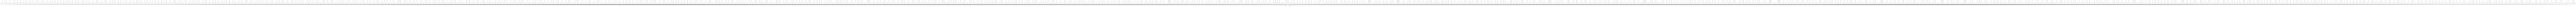

In [13]:
mean_ndvi_tiff.visualize("graph.png")

Finally, we can call the `compute` function on the `delayed` object and start the computation. The data will be downloaded, processed, and saved to GeoTiff. This process can take a lot of time! The slowest part is downloading data from STAC, not the calculations or saving itself.

In [14]:
%%time
output = mean_ndvi_tiff.compute() # output is a list of None objects

CPU times: user 868 ms, sys: 48.7 ms, total: 917 ms
Wall time: 7min 37s


In [15]:
!gdalinfo sentinel2_mean_ndvi.tif

Driver: GTiff/GeoTIFF
Files: sentinel2_mean_ndvi.tif
Size is 59398, 61354
Origin = (-172810.000000000000000,7817870.000000000000000)
Pixel Size = (20.000000000000000,-20.000000000000000)
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( -172810.000, 7817870.000) 
Lower Left  ( -172810.000, 6590790.000) 
Upper Right ( 1015150.000, 7817870.000) 
Lower Right ( 1015150.000, 6590790.000) 
Center      (  421170.000, 7204330.000) 
Band 1 Block=256x256 Type=Float64, ColorInterp=Gray
  Description = stackstac-9d589ff36255492afecafe05e8ace7ca


The result should look like this:

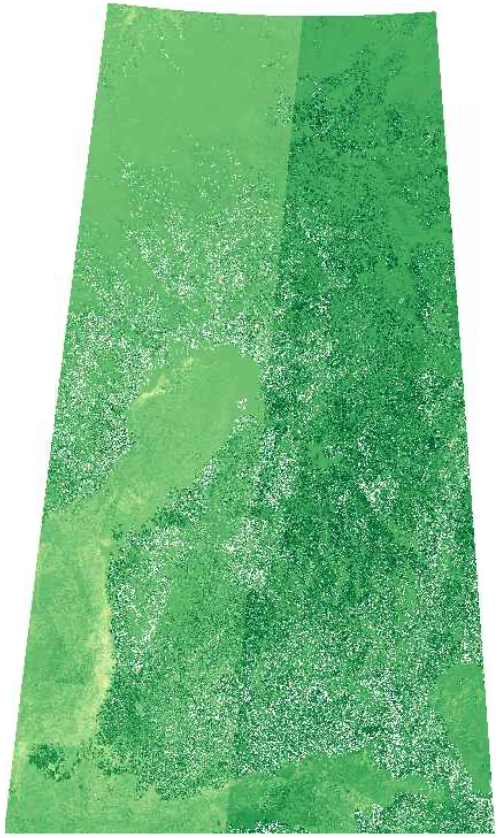

## Clean up

We can close the Dask cluster client to make sure the connection has ended.

In [16]:
client.close()